In [1]:
# imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import seaborn as sns
from pylab import rcParams

sns.set(style="ticks")
sns.set_style("whitegrid")
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['font.size'] = 20
rcParams['figure.figsize'] = (10,10)
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

## Load the webpage
---
In order to increase the readability of this notebook, the web scrapping process is written in the `web_scrapper` class and imported to this notebook. It scraps the summary and standings tables from https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2017 in the range between 2005 to 2017 and convert merge it to a giant dictionary with the year as the key and the summary detail of premier league in that year as the value.

In [3]:
from web_scrapper import web_scrapper

In [4]:
my_web_scrapper = web_scrapper()
try:
    my_web_scrapper.connect()
except requests.ConnectionError as detail:
    print(detail)

Request Succeeded!


In [5]:
summary_dfs = my_web_scrapper.digest()

In [6]:
summary_dfs[2005].head(3)

Avg. Market Values Avg. Player age     Club Full Name Club Short Name  \
0      13,04 Mill. €            24,5         Chelsea FC         Chelsea   
1       9,89 Mill. €            24,9  Manchester United         Man Utd   
2       6,63 Mill. €            23,3         Arsenal FC         Arsenal   

  Total Market Values  Position Goal Difference Points  
0      352,18 Mill. €         1              50     91  
1      286,93 Mill. €         2              38     83  
2      218,95 Mill. €         4              37     67

## Prepare the data
---
As we see above in the table, the data scrapped from https://www.transfermarkt.com are in good shape. However, we have to clean this data for machine learning's sake since model will only accept numeric inputs.

In [7]:
big_summary_df = pd.DataFrame()
for key, df in summary_dfs.items():
    df["Year"] = key
    big_summary_df = pd.concat((big_summary_df, df))

In [8]:
big_summary_df.reset_index(drop=True, inplace=True)
big_summary_df.tail(3)

Avg. Market Values Avg. Player age   Club Full Name Club Short Name  \
277       2,53 Mill. €            25,6     Norwich City         Norwich   
278       2,61 Mill. €            25,9   Leicester City       Leicester   
279       1,39 Mill. €            24,1  AFC Bournemouth     Bournemouth   

    Total Market Values  Position Goal Difference Points  Year  
277      103,75 Mill. €        19             -28     34  2015  
278       91,25 Mill. €         1              32     81  2015  
279       68,03 Mill. €        16             -22     42  2015

For the sake of readability, we can use a helper class which helps us to move the unit of both "Avg. Market Values" and "Total Market Values" to the column names. Then it can change all the cells that are numeric values to a proper data type.

In [9]:
from df_cleaner import df_cleaner

In [10]:
my_df_cleaner = df_cleaner()
numeric_big_summary_df = my_df_cleaner.cook(big_summary_df)
numeric_big_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 9 columns):
Avg. Market Values(Mill. €)     280 non-null float64
Avg. Player age                 280 non-null float64
Club Full Name                  280 non-null object
Club Short Name                 280 non-null object
Total Market Values(Mill. €)    280 non-null float64
Position                        280 non-null int64
Goal Difference                 280 non-null int64
Points                          280 non-null int64
Year                            280 non-null int64
dtypes: float64(3), int64(4), object(2)
memory usage: 19.8+ KB


In [11]:
numeric_big_summary_df.head(3)

Avg. Market Values(Mill. €)  Avg. Player age     Club Full Name  \
0                        14.12             24.7    Manchester City   
1                        12.31             23.8         Chelsea FC   
2                        12.70             23.5  Manchester United   

  Club Short Name  Total Market Values(Mill. €)  Position  Goal Difference  \
0        Man City                        621.40         3               41   
1         Chelsea                        603.30         1               52   
2         Man Utd                        533.25         6               25   

   Points  Year  
0      78  2016  
1      93  2016  
2      69  2016

## EDA
---
Before we feed the data to the model, it is important that we can analyse the data both visually and numerically first. It will give us more intuition of the problem we are trying to solve.

In [12]:
def color_strong_corr_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for strong correlations
    , black otherwise.
    """
    color = 'red' if (val > 0.6 or val < -0.6)  else 'black'
    return 'color: %s' % color

As the correlation table will be most intuitive, we can take a look which two numeric features have a strong correlation.

In [13]:
numeric_big_summary_df.corr().style.applymap(color_strong_corr_red)

We can see that total market values of a club has a relationship with both position and goal difference. Let's visualise this relationship.

In [14]:
g = sns.PairGrid(numeric_big_summary_df[numeric_big_summary_df["Year"]!=2018].iloc[:, :-1], height=5)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot)

## Training and Testing
---
Before regression, we need a mechanism to help us evaluating our prediction result. Thus, we need to split the dataset into training set and testing set.

Firstly, for convenience, the training set and test set will use abbreviated column names. However, for readability, plotting will still use the full name DataFrame 

In [37]:
training_set_df = numeric_big_summary_df.copy()

old_col_name_list = training_set_df.columns
training_set_df.rename(columns={
    old_col_name_list[0]: "avg_mv",
    old_col_name_list[1]: "avg_age",
    old_col_name_list[2]: "full",
    old_col_name_list[3]: "short",
    old_col_name_list[4]: "total_mv",
    old_col_name_list[5]: "pos",
    old_col_name_list[6]: "gd",
    old_col_name_list[7]: "pts",
    old_col_name_list[8]: "year",
}, inplace=True)

we need to split the 2018 year dataset since this is our objective in this project, to predict the standing of this year.

In [38]:
prediction_input_df = training_set_df[training_set_df["year"] == 2018]
training_set_df.drop(prediction_input_df.index, axis=0, inplace=True)

Secondly, the dataset need to be split to training set and testing set. The radio of training set is 80% and of testing set is 20%.

In [18]:
testing_set_df = training_set_df.sample(frac=0.2)
training_set_df.drop(testing_set_df.index, axis=0, inplace=True)

Take a look what two sets look like

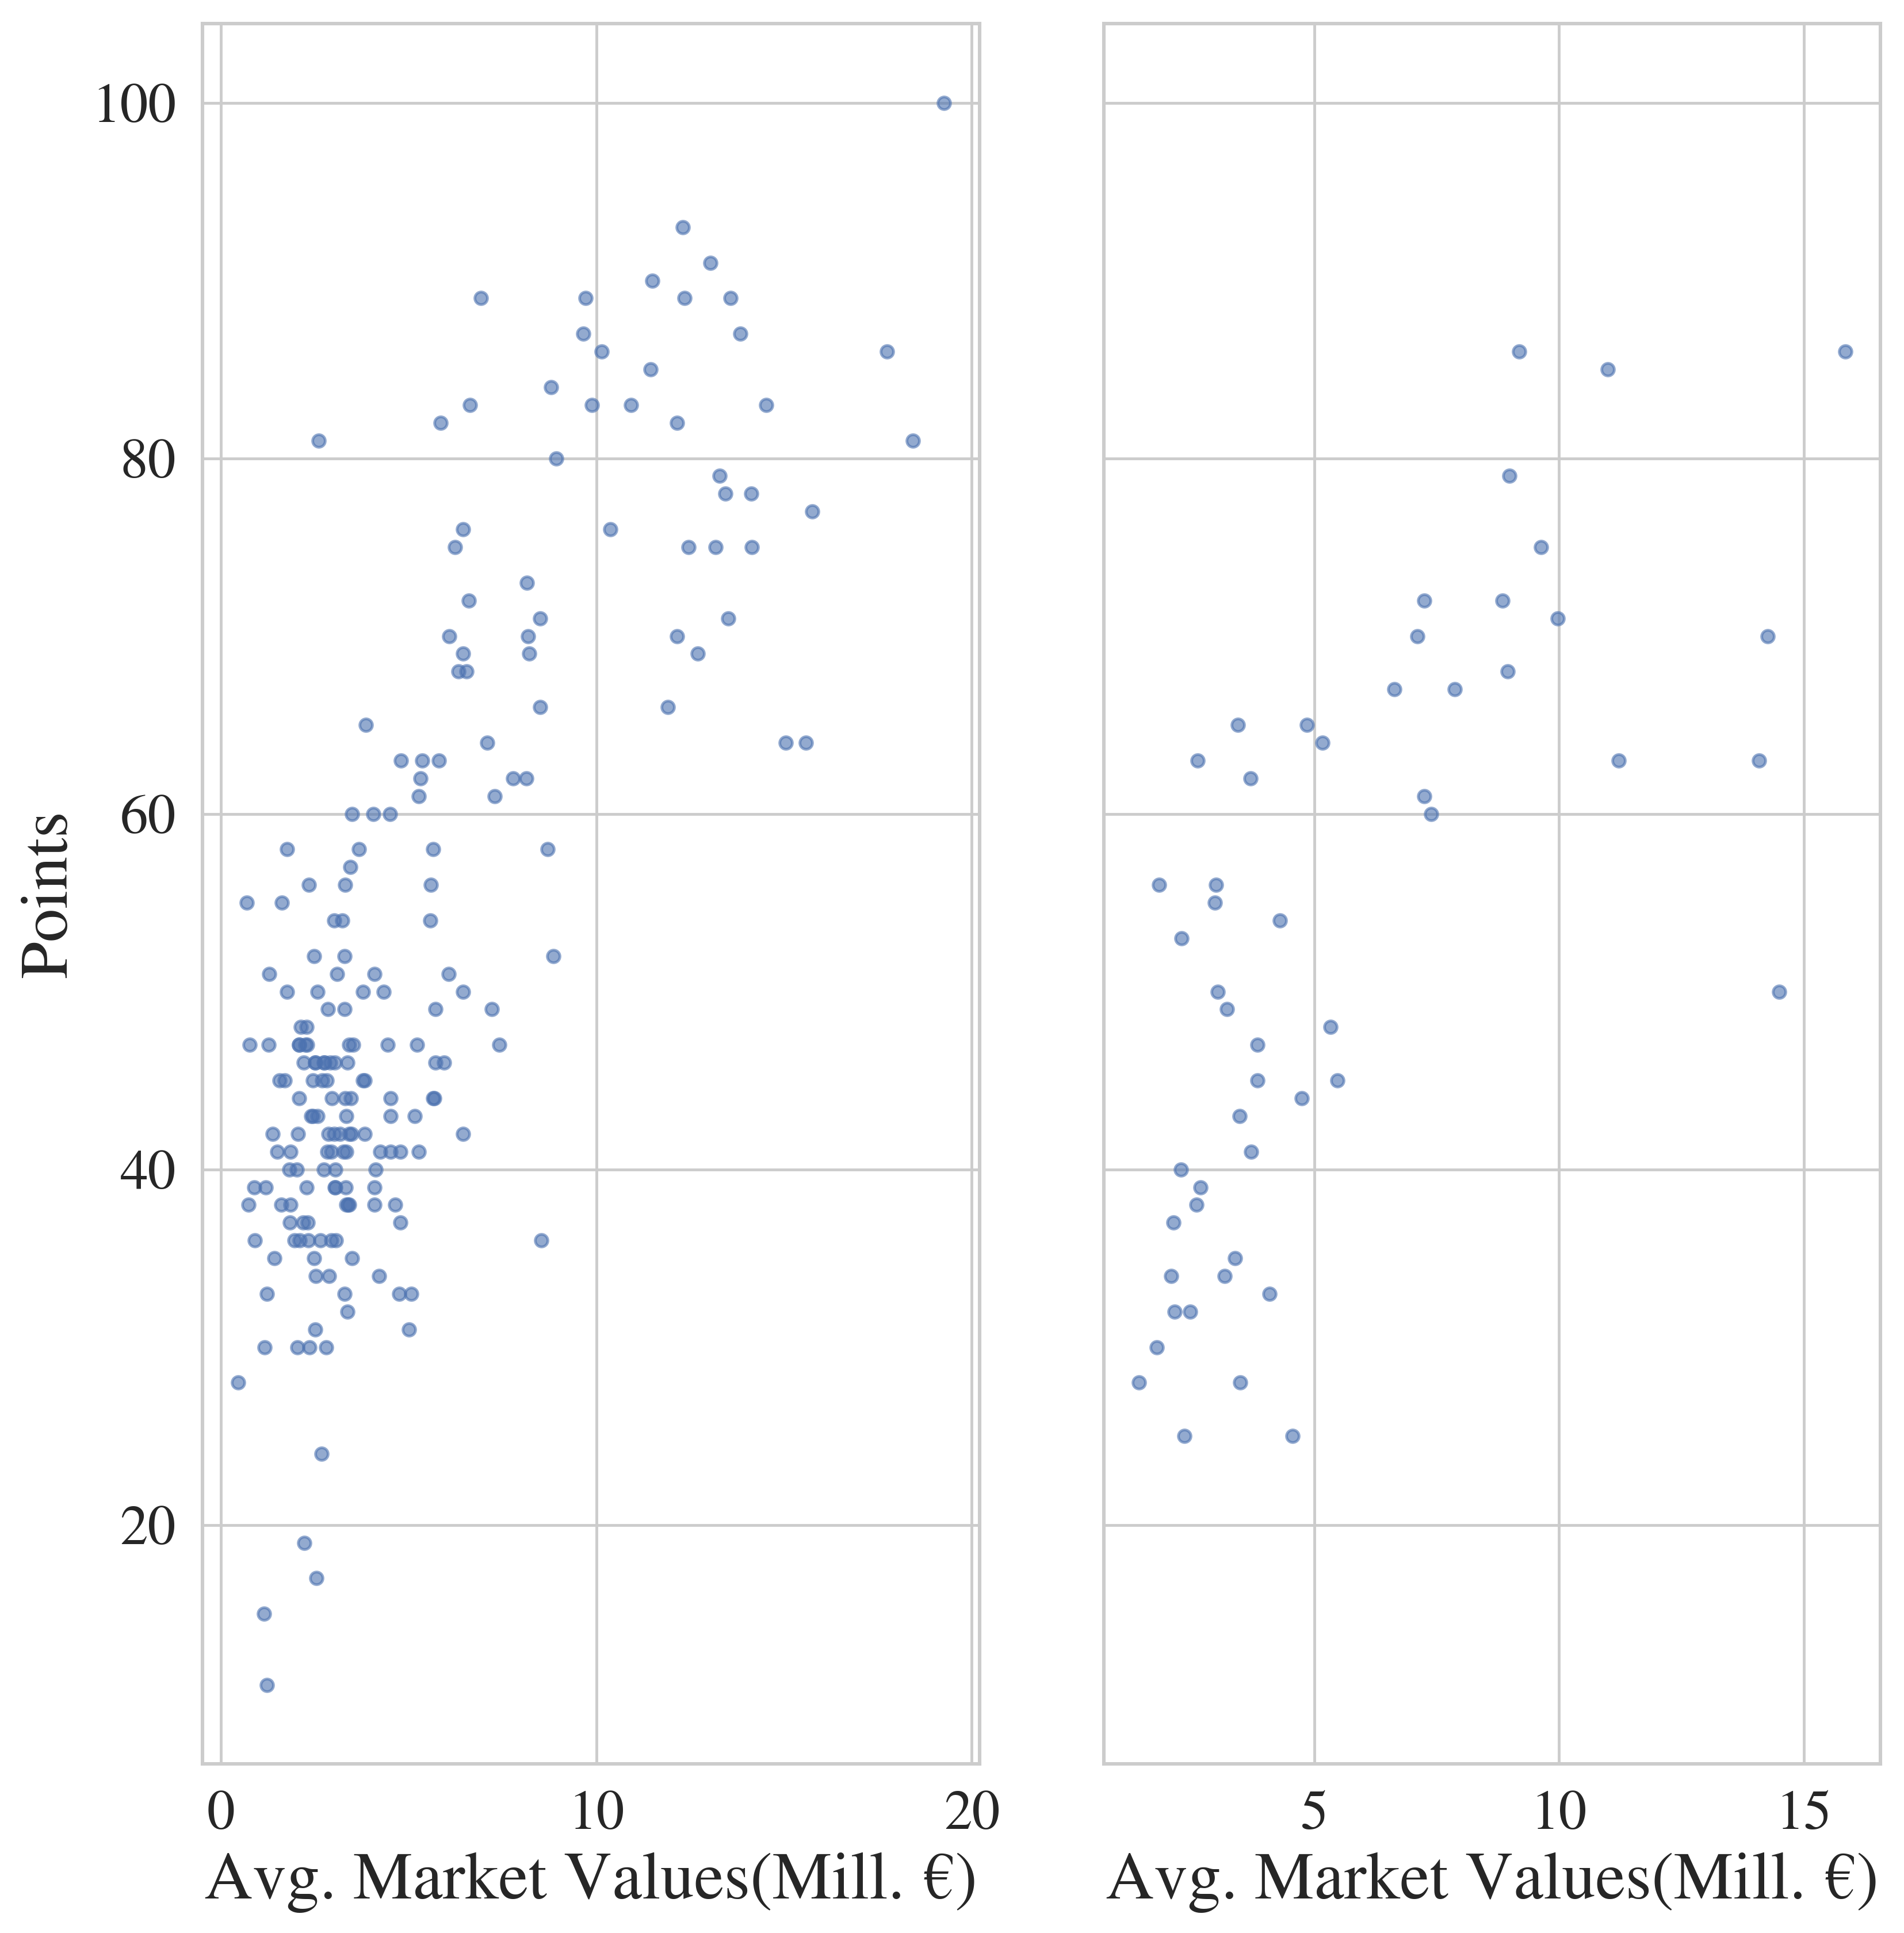

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(training_set_df.avg_mv, training_set_df.pts, s=20, alpha=0.6)
ax1.set_xlabel(numeric_big_summary_df.columns[0])
ax1.set_ylabel("Points")
ax2.scatter(testing_set_df.avg_mv, testing_set_df.pts, s=20, alpha=0.6)
ax2.set_xlabel(numeric_big_summary_df.columns[0])
fig.tight_layout()

## Linear Regression
---
Firstly, let's use a linear hypothesis function to describe the relationship, and evaluate the performance.

In [20]:
from ml_agent import linear_agent

It will be more intuitive for use to evaluate how good is our model to use a one-number evaluation.
To achieve this objective, we can calculate the square mean difference for the test set and prediction, the smaller the loss is, the better the model can predict.

$$
loss = \sum_{i=1}^{n} (y_i - h(x_i))^2
$$

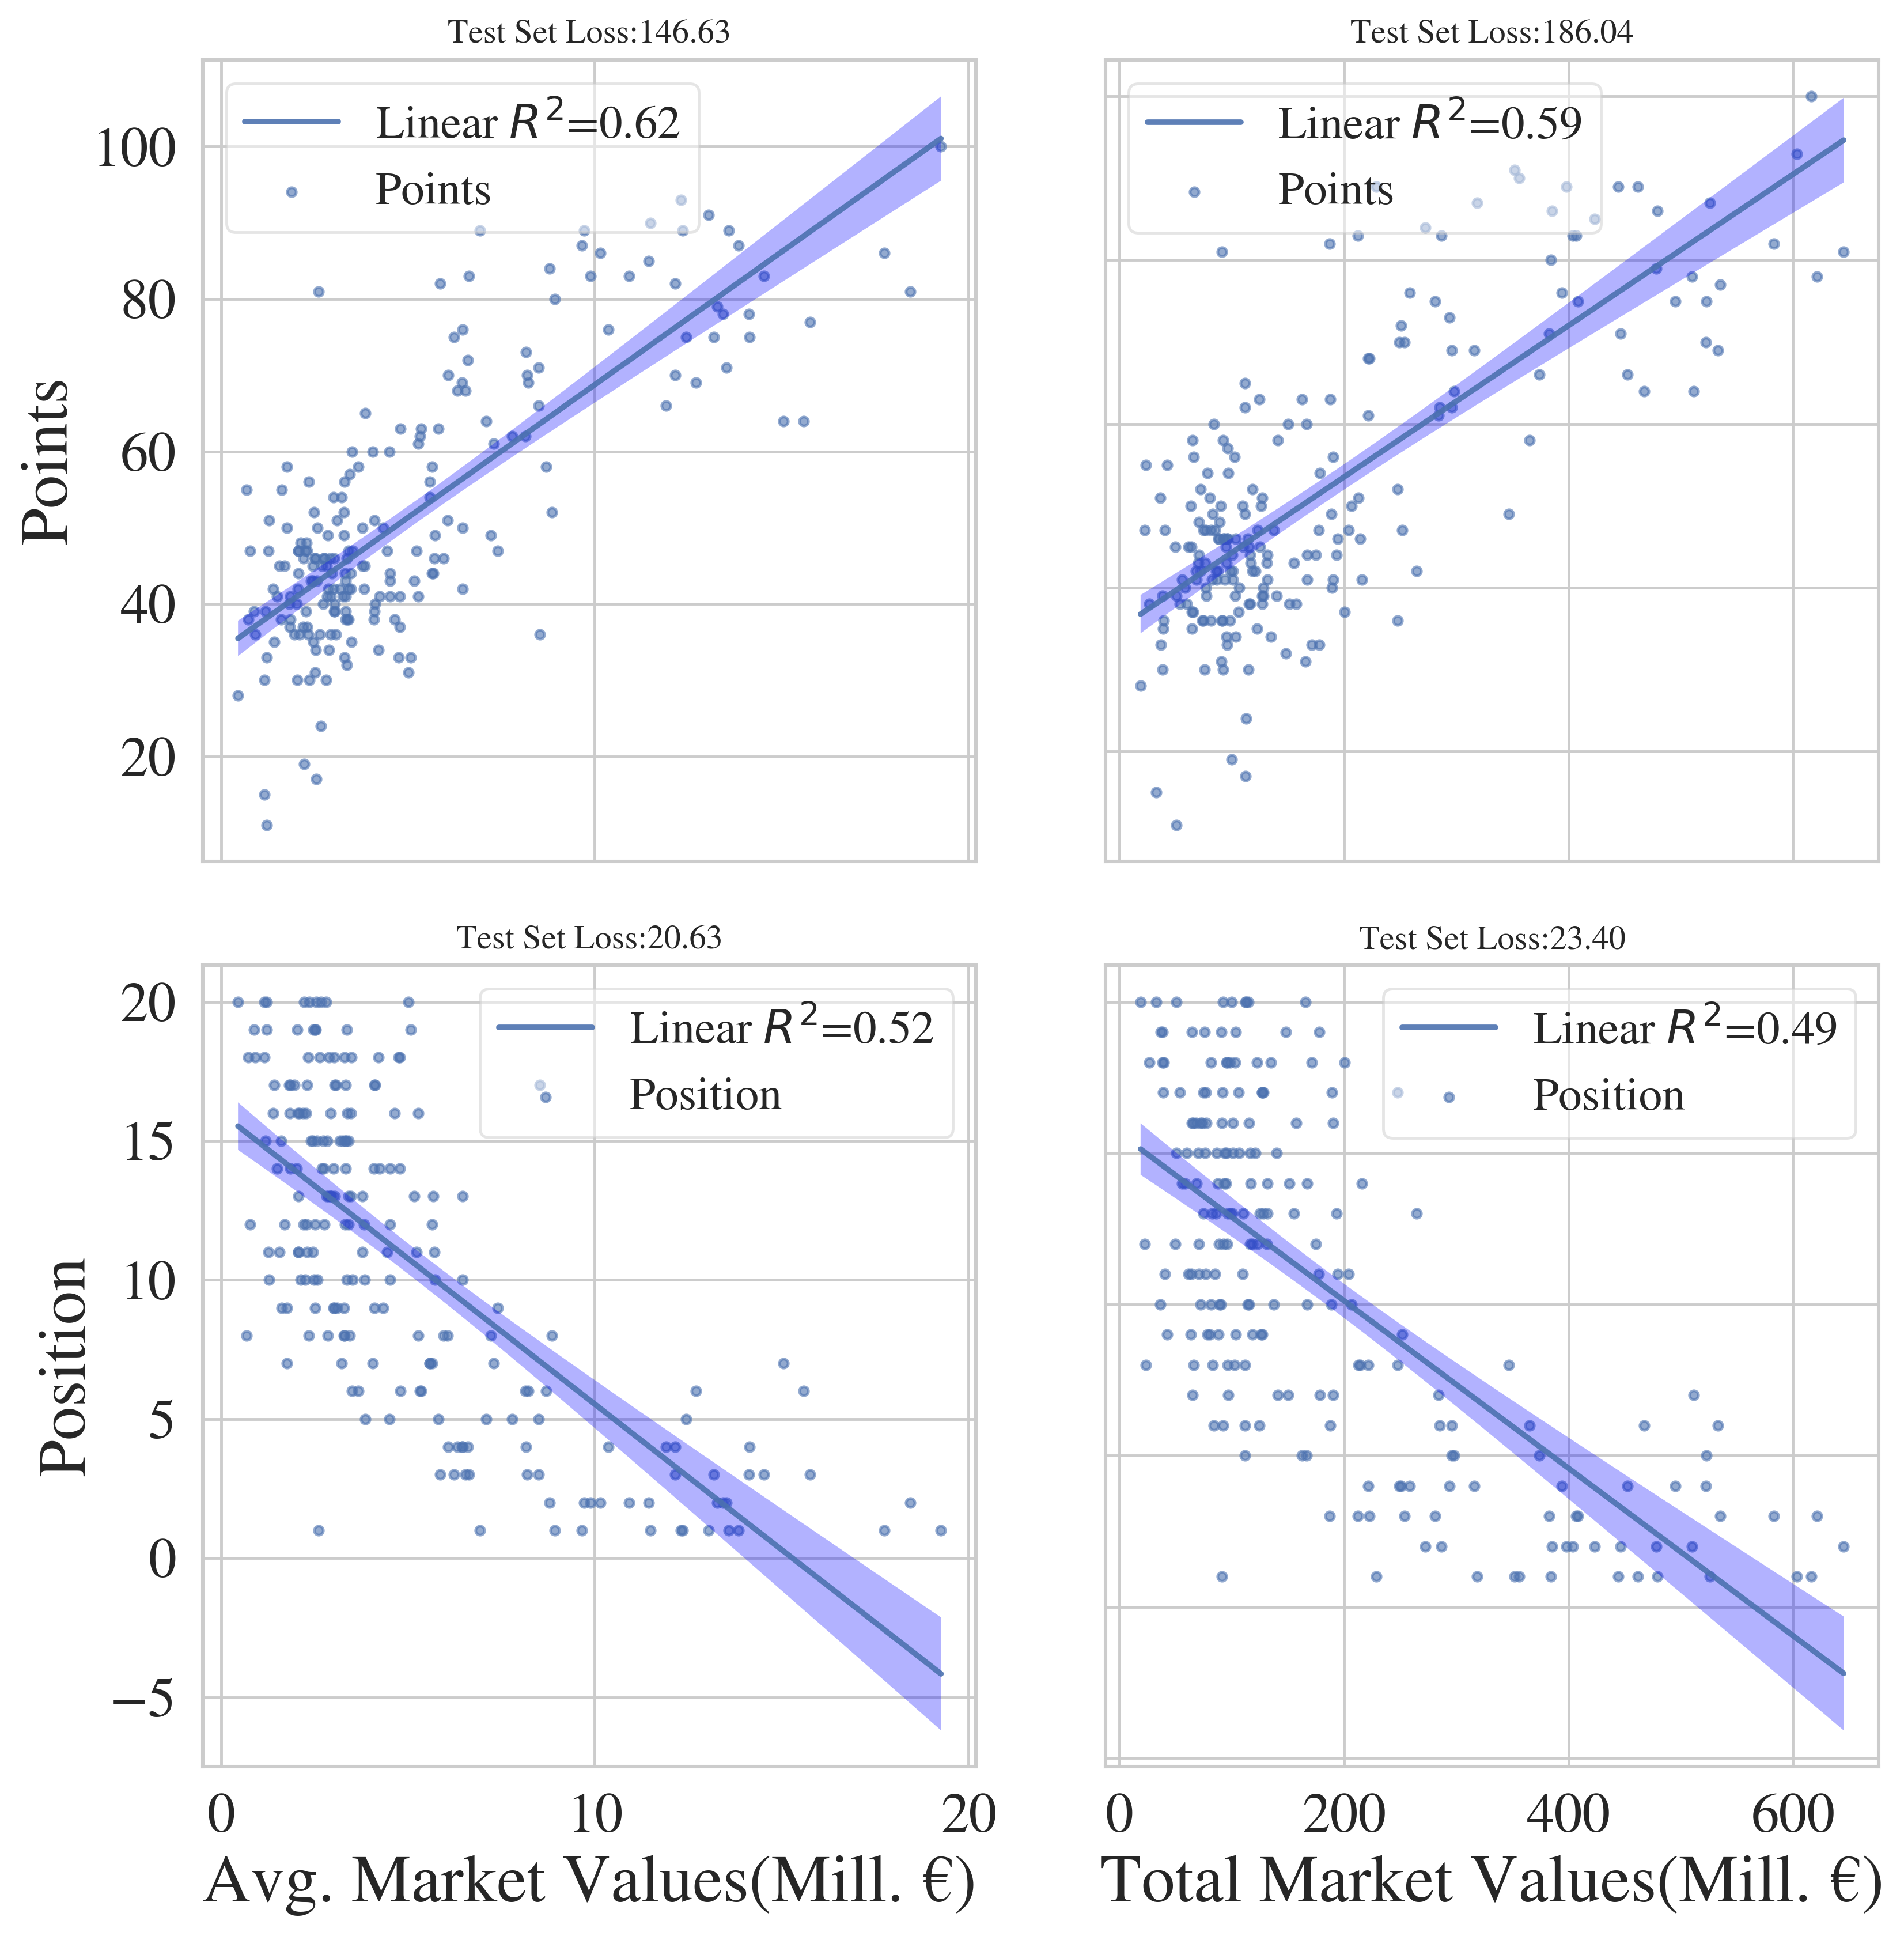

In [21]:
my_linear_agent = linear_agent(confidence=0.95)
my_linear_agent.train(train_data=training_set_df)
my_linear_agent.evaluate(train_data=training_set_df, test_data=testing_set_df, col_names=numeric_big_summary_df.columns)

From above plots we can observe that average market values is more accurate to predict. However, from the plots, intuitively we can see the linear hypothesis function is not confident enough for the training set. Will non-linear hypothesis function have a better performance to solve this problem? 

In [48]:
pd.concat((prediction_input_df.full, my_linear_agent.avg_pts_linear_model.predict(prediction_input_df)), axis=1).head(3)

full           0
40  Manchester City  166.374558
41     Liverpool FC  138.414457
42       Chelsea FC  132.278574

## Non-linear Regression